In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from math import log2
from IPython.display import display
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import median_absolute_error
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.pipeline import make_pipeline
import time
import matplotlib as mpl

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor



from sklearn.preprocessing import StandardScaler,PowerTransformer,MinMaxScaler,QuantileTransformer,normalize
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split

import pathlib
import os
import sys

# for selection the right path
import os,sys,inspect,pathlib
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from common.model_trainer_reg import *

from GD.LinearRegression import LinearRegression
from KNN.KNNRegressor import KNNRegressor

In [2]:
# Custom functions

module_path = pathlib.Path(os.getcwd()).parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))
print(sys.path)

from common.dataset_grabber import get_data_path

['/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2/Moneyball', '', '/home/alexander/ngsuite/ngsolve-install/lib/python3/dist-packages', '/home/alexander/ngsuite/ngsolve-install/bin', '/home/alexander/.local/bin', '/usr/local/sbin', '/usr/local/bin', '/usr/sbin', '/usr/bin', '/sbin', '/bin', '/usr/games', '/usr/local/games', '/snap/bin', '/home/alexander/.vscode/extensions/ms-toolsai.jupyter-2020.11.392013122/pythonFiles', '/home/alexander/.vscode/extensions/ms-toolsai.jupyter-2020.11.392013122/pythonFiles/lib/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/home/alexander/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages

In [3]:
def plot_corr_heatmap(df, fmt=".2f", feat_to_ret="W", ticksfont=12,abs = True):
    plt.rcParams.update({'font.size': 14, 'font.weight': 'bold'})
    # Compute correlations and save in matrix
    if abs:
        corr = np.abs(df.corr()) # We only used absolute values for visualization purposes! ..."hot-cold" view to just sort between 
    else:
        corr = df.corr()

    # Mask the repeated values --> here: upper triangle

    #print(corr)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True # mask upper triangle

    corr_to_feat = corr.loc[:,feat_to_ret]
    
    f, ax = plt.subplots(figsize=(18, 16))
    sns.heatmap(corr, annot=True, fmt=fmt , mask=mask, vmin=0, vmax=1, linewidths=.5,cmap="YlGnBu")
    plt.tick_params(labelsize=ticksfont)
    plt.savefig("out/heatmap_voting.pdf")
    return corr_to_feat

In [4]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")
    plt.grid()
    return plt

In [5]:
datapath = get_data_path("Moneyball", "baseball.csv")
display(datapath)

PosixPath('/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2/Datasets/Moneyball/baseball.csv')

In [6]:
df_raw = pd.read_csv(datapath)

df_raw

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,PHI,NL,1962,705,759,81,0.330,0.390,0.260,0,NaN,NaN,161,NaN,NaN
1228,PIT,NL,1962,706,626,93,0.321,0.394,0.268,0,NaN,NaN,161,NaN,NaN
1229,SFG,NL,1962,878,690,103,0.341,0.441,0.278,1,1.0,2.0,165,NaN,NaN
1230,STL,NL,1962,774,664,84,0.335,0.394,0.271,0,NaN,NaN,163,NaN,NaN


# Data explenarision

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          1232 non-null   object 
 1   League        1232 non-null   object 
 2   Year          1232 non-null   int64  
 3   RS            1232 non-null   int64  
 4   RA            1232 non-null   int64  
 5   W             1232 non-null   int64  
 6   OBP           1232 non-null   float64
 7   SLG           1232 non-null   float64
 8   BA            1232 non-null   float64
 9   Playoffs      1232 non-null   int64  
 10  RankSeason    244 non-null    float64
 11  RankPlayoffs  244 non-null    float64
 12  G             1232 non-null   int64  
 13  OOBP          420 non-null    float64
 14  OSLG          420 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 144.5+ KB


In [8]:
1976 + 1624

3600

In [9]:
360000 / (1232*15)

19.48051948051948

# Description of data columns

RS ... Runs Scored, 

RA ... Runs Allowed

***RD ... Run differential (actually difference)***

W ... Wins

OBP ... On-Base Percentage

SLG ... Slugging Percentage

BA ... Batting Average

Playoffs (binary)

RankSeason

RankPlayoffs

G ... Games Played

OOBP ... Opponent On-Base Percentage

OSLG ... Opponent Slugging Percentage

In [10]:
cols_to_drop = ['Team', 'League', 'Year', 'RankSeason', 'RankPlayoffs', 'Playoffs']
df_prep = df_raw.drop(cols_to_drop, axis=1)

# Fix missing values and type
df_prep.replace("?",0, inplace=True)
#df_prep = df_prep[df_prep.OOBP != 0]
df_prep[['OOBP','OSLG']] = df_prep[['OOBP','OSLG']].astype(float)

In [11]:
df_prep

,RS,RA,W,OBP,SLG,BA,G,OOBP,OSLG
0,734,688,81,0.328,0.418,0.259,162,0.317,0.415
1,700,600,94,0.320,0.389,0.247,162,0.306,0.378
2,712,705,93,0.311,0.417,0.247,162,0.315,0.403
3,734,806,69,0.315,0.415,0.260,162,0.331,0.428
4,613,759,61,0.302,0.378,0.240,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...
1227,705,759,81,0.330,0.390,0.260,161,NaN,NaN
1228,706,626,93,0.321,0.394,0.268,161,NaN,NaN
1229,878,690,103,0.341,0.441,0.278,165,NaN,NaN
1230,774,664,84,0.335,0.394,0.271,163,NaN,NaN


# Handling missingvalues

420 Nan values are in the OOBP and OSLG column.

1) Stategie is to drop these rows with the Nan values. The impact of this stategie is that the dataset shrinks.

2) calculate the mean value from all other values in the column and replace it with it.

In [12]:
r_mean = np.mean(df_prep["OOBP"])
print(r_mean)
df_prep_mean = df_prep.replace(float('NaN'),r_mean)
r_mean = np.mean(df_prep["OSLG"])
print(r_mean)
df_prep_mean  = df_prep_mean.replace(float('NaN'),r_mean)

0.3322642857142857
0.41974285714285714


In [13]:
df_prep_mean

,RS,RA,W,OBP,SLG,BA,G,OOBP,OSLG
0,734,688,81,0.328,0.418,0.259,162,0.317000,0.415000
1,700,600,94,0.320,0.389,0.247,162,0.306000,0.378000
2,712,705,93,0.311,0.417,0.247,162,0.315000,0.403000
3,734,806,69,0.315,0.415,0.260,162,0.331000,0.428000
4,613,759,61,0.302,0.378,0.240,162,0.335000,0.424000
...,...,...,...,...,...,...,...,...,...
1227,705,759,81,0.330,0.390,0.260,161,0.332264,0.332264
1228,706,626,93,0.321,0.394,0.268,161,0.332264,0.332264
1229,878,690,103,0.341,0.441,0.278,165,0.332264,0.332264
1230,774,664,84,0.335,0.394,0.271,163,0.332264,0.332264


In [14]:
df_prep_nomiss = df_prep.dropna()
df_prep_nomiss

,RS,RA,W,OBP,SLG,BA,G,OOBP,OSLG
0,734,688,81,0.328,0.418,0.259,162,0.317,0.415
1,700,600,94,0.320,0.389,0.247,162,0.306,0.378
2,712,705,93,0.311,0.417,0.247,162,0.315,0.403
3,734,806,69,0.315,0.415,0.260,162,0.331,0.428
4,613,759,61,0.302,0.378,0.240,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...
415,872,831,86,0.356,0.434,0.271,162,0.345,0.423
416,809,838,75,0.338,0.426,0.262,161,0.355,0.427
417,772,913,69,0.343,0.411,0.274,162,0.371,0.448
418,945,859,95,0.361,0.479,0.293,162,0.346,0.459


# Distributions from the taget-clomum

In [15]:
np.mean(df_prep_nomiss["W"])

80.95714285714286

80.95714285714286


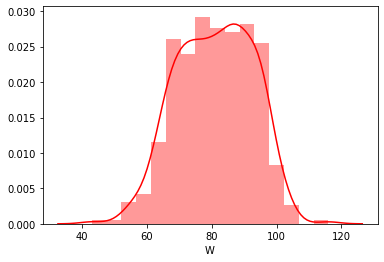

In [16]:
print(np.mean(df_prep_nomiss["W"]))
plot = sns.distplot(df_prep_nomiss["W"], color="red")
plt.savefig("out/explornation/nomiss.png")

80.90422077922078


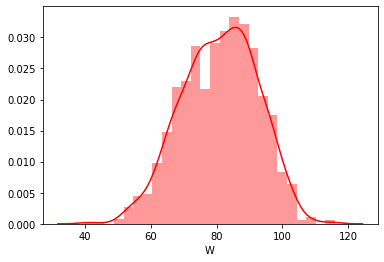

In [17]:
print(np.mean(df_prep_mean["W"]))
sns.distplot(df_prep_mean["W"], color="red")
plt.savefig("out/explornation/mean.png")

almoast looks like a distribution -> indicates a good regression

# Train and Test

In [27]:
#Y = df_prep_mean[['W']]   # does not work with TrainTestSplit and CrossValidation
# works if the parameter is a pandas.core.series.Series
Y = df_prep_mean["W"]
print(type(Y))

#Y = df_prep_mean.W
#print(type(Y))
X = df_prep_mean[["RS","RA","OBP","SLG","BA","G","OOBP","OSLG"]]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)



<class 'pandas.core.series.Series'>


In [28]:
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state = 42)
#MODEL = SGDRegressor()
#train_sizes, train_scores, test_scores, fit_times = learning_curve(MODEL, x_train, y_train, return_times=True, train_sizes=train_sizes)

In [29]:
#cv = train_test_split(X, Y, test_size = 0.4, random_state = 42)
#train_sizes, train_scores = learning_curve(MODEL, X, Y)

## SGD-Regression

In [30]:
MODEL = SGDRegressor
NAME = "SGD"
PATH = "out/"+NAME+"/"
params = {"alpha" : [0.0001]}

modeltrainer = ModelTrainer(MODEL, params, X, Y, f_eval=r2_score, Varerror=mean_gamma_deviance, Error="MGE")
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.3)
#modeltrainer.CV_fold(k = 6)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = 6)
modeltrainer.train()
res = modeltrainer.result
display(res)

Finished evaluation
R2_score= 0.8801895788437764
Total evaluation time = 0.20s


,alpha,train_time,inference_time,R2_score,RMSE,MGE
0,0.0001,0.006919,0.000418,0.88019,16.179029,0.002816


Finished evaluation
R2_score= 0.8906506845077311
Total evaluation time = 0.21s


,alpha,train_time,inference_time,R2_score,RMSE,MGE
0,0.0001,0.008364,0.000344,0.890651,17.607137,0.002933


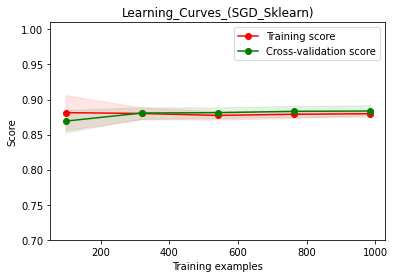

In [31]:
plt.figure()
plt.grid()

title = "Learning_Curves_(SGD_Sklearn)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = SGDRegressor()
plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.savefig(PATH+title)
plt.show()

In [32]:
MODEL = LinearRegression
params = {"alpha" : [0.0001,0.00001, 0.000001],
         "max_iter": [1000,10000,100000], 
         "weigths": ["residual"]}

modeltrainer = ModelTrainer(MODEL, params, X, Y, f_eval=r2_score, Varerror=mean_gamma_deviance, Error="MGE")
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.3)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = 6)
modeltrainer.train()
res = modeltrainer.result
display(res)

Finished evaluation
R2_score= 0.2993685702536959
Total evaluation time = 3.70s


,alpha,max_iter,weigths,train_time,inference_time,R2_score,RMSE,MGE
0,0.000100,1000,residual,0.180914,0.056316,0.298312,94.75492,0.015171
1,0.000100,10000,residual,0.733751,0.037506,0.298312,94.75492,0.015171
2,0.000100,100000,residual,3.573818,0.012492,0.298312,94.75492,0.015171
3,0.000010,1000,residual,0.176192,0.073262,0.298312,94.75492,0.015171
4,0.000010,10000,residual,0.830292,0.018099,0.298312,94.75492,0.015171
5,0.000010,100000,residual,3.490198,0.010741,0.298312,94.75492,0.015171
6,0.000001,1000,residual,0.163992,0.065734,0.299369,94.61227,0.015188
7,0.000001,10000,residual,0.833627,0.024899,0.298312,94.75492,0.015171
8,0.000001,100000,residual,3.146712,0.018796,0.298312,94.75492,0.015171


Finished evaluation
R2_score= 0.2628139960799598
Total evaluation time = 4.01s


,alpha,max_iter,weigths,train_time,inference_time,R2_score,RMSE,MGE
0,0.000100,1000,residual,0.128528,0.020466,0.260259,119.111133,0.020057
1,0.000100,10000,residual,1.011257,0.007828,0.260259,119.111133,0.020057
2,0.000100,100000,residual,3.192493,0.008801,0.260259,119.111133,0.020057
3,0.000010,1000,residual,0.139474,0.025336,0.260259,119.111133,0.020057
4,0.000010,10000,residual,1.086497,0.034334,0.260259,119.111133,0.020057
5,0.000010,100000,residual,3.807807,0.006835,0.260259,119.111133,0.020057
6,0.000001,1000,residual,0.174291,0.021182,0.262814,118.699734,0.020065
7,0.000001,10000,residual,0.980573,0.023166,0.260259,119.111133,0.020057
8,0.000001,100000,residual,3.680736,0.006150,0.260259,119.111133,0.020057


## KNN-Regression

In [33]:
MODEL = KNeighborsRegressor
params = {"weights" : ["uniform"]}
NAME = "KNN"
PATH = "out/"+NAME+"/"

modeltrainer = ModelTrainer(MODEL, params, X, Y, f_eval=r2_score, Varerror=mean_gamma_deviance, Error="MGE")
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.3)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = 6)
modeltrainer.train()
res = modeltrainer.result
display(res)

Finished evaluation
R2_score= 0.7911988030798872
Total evaluation time = 0.19s


,weights,train_time,inference_time,R2_score,RMSE,MGE
0,uniform,0.003922,0.008048,0.791199,28.196216,0.004658


Finished evaluation
R2_score= 0.7608583672466888
Total evaluation time = 0.18s


,weights,train_time,inference_time,R2_score,RMSE,MGE
0,uniform,0.002631,0.009665,0.760858,38.505951,0.006511


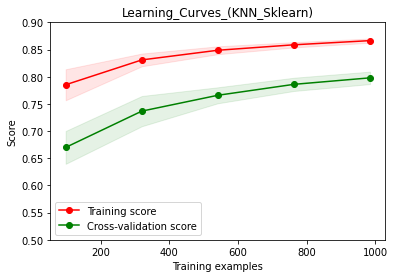

In [34]:
plt.figure()
plt.grid()

title = "Learning_Curves_(KNN_Sklearn)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#cv = train_test_split(test_size=0.4, random_state=42)

estimator = KNeighborsRegressor()
plot_learning_curve(estimator, title, X, Y, ylim=(0.5, 0.90), cv=cv, n_jobs=4)
plt.savefig(PATH+title)
plt.show()

## RF-Regression

In [35]:
MODEL = RandomForestRegressor
params = {"n_estimators" : [100]}
NAME = "RF"
PATH = "out/"+NAME+"/"

modeltrainer = ModelTrainer(MODEL, params, X, Y, f_eval=r2_score)
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.3)
#modeltrainer.CV_fold(k = 6)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = 6)
modeltrainer.train()
res = modeltrainer.result
display(res)

Finished evaluation
R2_score= 0.8675762438577057
Total evaluation time = 0.70s


,n_estimators,train_time,inference_time,R2_score,RMSE
0,100,0.516658,0.022349,0.867576,17.882315


Finished evaluation
R2_score= 0.8412176350728873
Total evaluation time = 0.78s


,n_estimators,train_time,inference_time,R2_score,RMSE
0,100,0.593389,0.013389,0.841218,25.566715


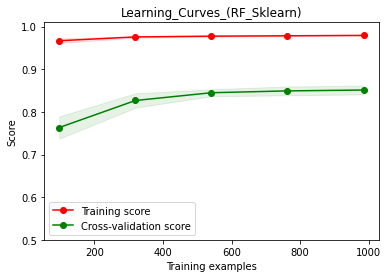

In [36]:
plt.figure()
plt.grid()

title = "Learning_Curves_(RF_Sklearn)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#cv = train_test_split(test_size=0.4, random_state=42)

estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X, Y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.savefig(PATH+title)
plt.show()

## DT-Regression

In [37]:
MODEL = DecisionTreeRegressor
params = {"criterion": ["mse"]}
NAME = "DT"
PATH = "out/"+NAME+"/"

modeltrainer = ModelTrainer(MODEL, params, X, Y, f_eval=r2_score, Varerror=mean_gamma_deviance, Error="MGE")
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.3)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = 6)
modeltrainer.train()
res = modeltrainer.result
display(res)

Finished evaluation
R2_score= 0.7514624098159652
Total evaluation time = 0.19s


,criterion,train_time,inference_time,R2_score,RMSE,MGE
0,mse,0.006662,0.000352,0.751462,33.562162,0.005597


Finished evaluation
R2_score= 0.7102266463358946
Total evaluation time = 0.19s


,criterion,train_time,inference_time,R2_score,RMSE,MGE
0,mse,0.008096,0.000343,0.710227,46.658537,0.007657


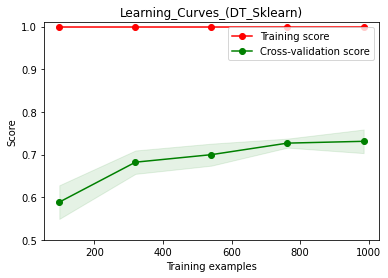

In [38]:
plt.figure()
plt.grid()

title = "Learning_Curves_(DT_Sklearn)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#cv = train_test_split(test_size=0.4, random_state=42)

estimator = DecisionTreeRegressor()
plot_learning_curve(estimator, title, X, Y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.savefig(PATH+title)
plt.show()